<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Data Preparation and Model Training

In [ ]:
import os
from google.colab import drive
from google.colab import files

#for image processing
!pip install pillow
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

#for metadata
import pandas as pd

#for data file structure
import os
import shutil

#for modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchsummary import summary

## Step 1: Link Notebook to GitHub and Google Drive

In [1]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "BrainAgingComputerVision" # Enter repo name
git_path = 'https://github.com/MRWilliamsGit/BrainAgingComputerVision.git'
!git clone "{git_path}"

#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Connect to Google Drive
drive.mount('/content/gdrive')
#%cd gdrive/MyDrive/School

Cloning into 'BrainAgingComputerVision'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 86 (delta 28), reused 27 (delta 26), pack-reused 55
Unpacking objects: 100% (86/86), done.
Mounted at /content/gdrive


## Step 2: Convert and Sort Images

In [2]:
#import files
!unzip '/content/gdrive/My Drive/School/image_data.zip' > /dev/null

7221032


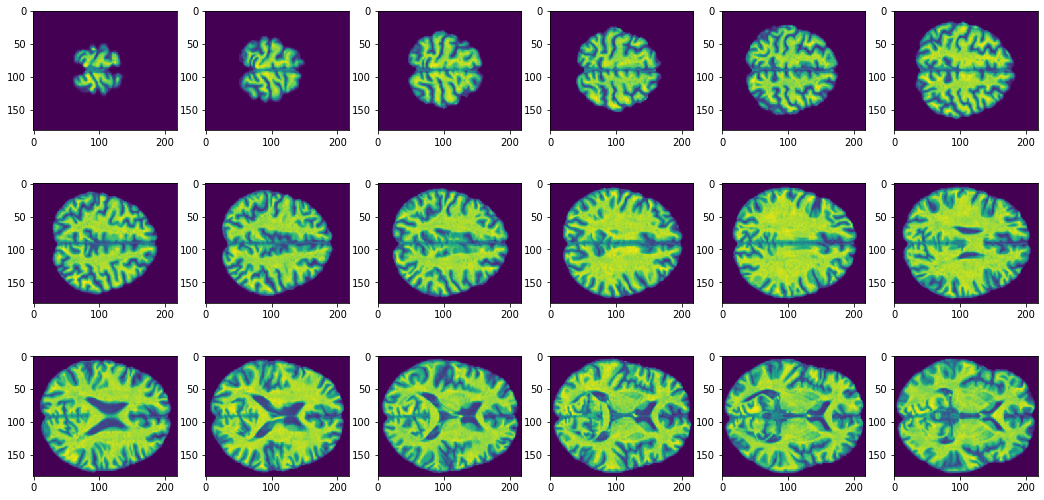

In [15]:
#pick an image to take a look at
image_path = '/content/image_data/0_A_train.npy'
image3D = np.load(image_path)

#show image size (218*182*182)
print(image3D.size)

#loop to show slices, start at slice 10
plt.rcParams['figure.figsize'] = [18, 9]
fig, axs = plt.subplots(3, 6)
i = 10
for m in range(3):
  for w in range(6):
    im = Image.fromarray((image3D[i] * 255).astype(np.uint8))
    axs[m, w].imshow(im, interpolation='nearest')
    i += 5

#fig.savefig("slices.png")

In [16]:
#pull up image metadata
filein = '/content/gdrive/My Drive/School/cn_age_df.csv'
data = pd.read_csv(filein)
#data.head()


In [ ]:
#establish the file structure required for the dataloaders
folders = ['50','60','70','80','90']
os.mkdir("/content/data/")

for i in folders:
  base = '/content/data'
  path = os.path.join(base, i,)
  os.mkdir(path)

In [ ]:
#pull out image slice, convert to jpeg, then move to class (age) folder
#note: conversion to jpeg lets us use the datasets.Imageloader
#note: images will be converted to tensors during transform since loaders can't process images

#this is the slice picked from the 3D image
imslice = 50

for i in range(len(data)):

  #first load the image, pull out a slice and convert it to jpeg
  imgpl1 = "/content/image_data/" + data.loc[i][0] + '.npy'
  imgjpl = "/content/image_data/" + data.loc[i][0] + '.jpg'
  image3D = np.load(imgpl1)
  im = Image.fromarray((image3D[imslice] * 255).astype(np.uint8))
  im.save(imgjpl)

  #then loop through to determine which folder it belongs to
  for f in folders:
    if data.loc[i][5] < int(f):
      #if less than the folder name, move to the folder before f
      imgpl2 = "/content/data/" + str(int(f)-10) + "/" + data.loc[i][0] + '.jpg'
      os.rename(imgjpl, imgpl2)
      break
    elif data.loc[i][5] >= 90:
      imgpl2 = "/content/data/90/" + data.loc[i][0] + '.jpg'
      os.rename(imgjpl, imgpl2)
      break

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 3: Load into DataLoaders

In [ ]:
#this loads full dataset into dataloader

#get dataset
dataset = datasets.ImageFolder('/content/data/')

#define transformation
data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.Grayscale(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5],std=[0.5])])

#get dataset with transformation
dataset = datasets.ImageFolder('/content/data/', transform=data_transform)

#add to loader
batch_size = 4
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#set up class names for visualizations and checking
idx_to_class = {i:j for i,j in enumerate(folders)}
class_to_idx = {v:k for k,v in idx_to_class.items()}

torch.Size([4, 1, 224, 224])


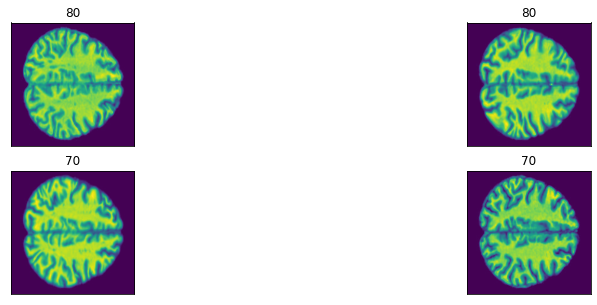

In [ ]:
# Visualize a batch of images (note they were compressed sideways)
images, labels = iter(loader).next()
print(images.shape)
images = images.numpy() # Convert images to numpy for display
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
# note that images are greyscale, it's just the plot aesthetic that makes them colorful
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(idx_to_class[labels[idx]])

In [ ]:
#training/test split example - not yet working

def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/data/', transform=Compose([Resize((224,224)),ToTensor()]))
#print(len(dataset))
datasets = train_val_dataset(dataset)
#print(len(datasets['train']))
#print(len(datasets['val']))
#The original dataset is available in the Subset class
#print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

#https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/

## Step 4: Define and Train Model

In [ ]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)

# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was originally trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (5)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 5)

# Display a summary of the layers of the model and output shape after each layer
summary(model_resnet,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 112, 112]           3,136
       BatchNorm2d-2          [4, 64, 112, 112]             128
              ReLU-3          [4, 64, 112, 112]               0
         MaxPool2d-4            [4, 64, 56, 56]               0
            Conv2d-5            [4, 64, 56, 56]          36,864
       BatchNorm2d-6            [4, 64, 56, 56]             128
              ReLU-7            [4, 64, 56, 56]               0
            Conv2d-8            [4, 64, 56, 56]          36,864
       BatchNorm2d-9            [4, 64, 56, 56]             128
             ReLU-10            [4, 64, 56, 56]               0
       BasicBlock-11            [4, 64, 56, 56]               0
           Conv2d-12            [4, 64, 56, 56]          36,864
      BatchNorm2d-13            [4, 64, 56, 56]             128
             ReLU-14            [4, 64,

In [ ]:
#train function copied from example
def train_model(model,criterion,optimizer,loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_corrects = 0
        
        for i, data in enumerate(loader):
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item() * inputs.size(0)
            # Track number of correct predictions
            running_corrects += torch.sum(preds == labels.data)
            
        # Calculate and display average loss and accuracy for the epoch
        epoch_loss = running_loss / len(dataset)
        epoch_acc = running_corrects.double() / len(dataset)
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        loss_over_time.append(epoch_loss)

    return loss_over_time

Loss: 1.3288 Acc: 0.5185
Loss: 1.3135 Acc: 0.5272
Loss: 1.2768 Acc: 0.5422
Loss: 1.2666 Acc: 0.5541
Loss: 1.2491 Acc: 0.5596
Loss: 1.2256 Acc: 0.5754
Loss: 1.2243 Acc: 0.5738
Loss: 1.2018 Acc: 0.5762
Loss: 1.1889 Acc: 0.5793
Loss: 1.1956 Acc: 0.5785
Loss: 1.1780 Acc: 0.5983
Loss: 1.1979 Acc: 0.5754
Loss: 1.1764 Acc: 0.5777
Loss: 1.1540 Acc: 0.6188
Loss: 1.1648 Acc: 0.6069
Loss: 1.1520 Acc: 0.5927
Loss: 1.1365 Acc: 0.6180
Loss: 1.1566 Acc: 0.5919
Loss: 1.1180 Acc: 0.6259
Loss: 1.1024 Acc: 0.6259


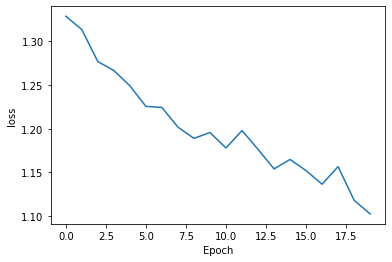

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,loader,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

TypeError: ignored

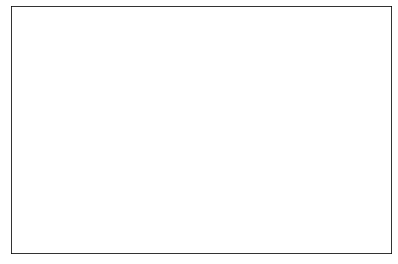

In [ ]:
# Display a batch of predictions
# Note that this will be good since we didn't separate out a test set yet

def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        #image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(model_resnet,loader,device)

## Step 5: Save Model

In [ ]:
# OPTION 1: Save the state dictionary of the model
model_dir = 'models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'model_state_dict.pt'

# Save the model's learned parameters (state_dict)
torch.save(model_resnet.state_dict(), model_dir+filename)

# Initialize new model and load state dict previously saved into it
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
in_channels = 1
model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

model = model.to(device)
model.load_state_dict(torch.load(model_dir+filename, map_location=device))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Test loaded model
#acc = test_model(model,testloader,device)
#print()
#print('Test set accuracy is {:.3f}'.format(acc))

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

In [ ]:
# OPTION 2: Save the entire model

model_dir = 'models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'fullmodel.pt'

# Save the entire model
torch.save(model_resnet, model_dir+filename)

# Load model
model2 = torch.load(model_dir+filename)

# Test loaded model
#acc = test_model(model2,testloader,device)
#print('Test set accuracy is {:.3f}'.format(acc))

In [ ]:
#download
#files.download('/content/models/fullmodel.pt')
#files.download('/content/models/model_state_dict.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>